Setup the environment, if needed

In [2]:
## Update the following with your specific version of CUDA, if any. 
# !pip install torch --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install h5py pandas numpy matplotlib diffusers transformers scipy ftfy pyarrow regex wordcloud


  Using cached h5py-3.7.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (4.5 MB)
  Using cached pandas-1.5.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached numpy-1.23.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached matplotlib-3.6.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)
  Using cached diffusers-0.6.0-py3-none-any.whl (255 kB)
  Using cached transformers-4.23.1-py3-none-any.whl (5.3 MB)
  Using cached scipy-1.9.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (33.8 MB)
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 30.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.0/770.0 kB 72.1 MB/s eta 0:00:00
  Using cached wordcloud-1.8.2.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (458 kB)
  Using cached pytz-2022.5-py2.py3-none-any.whl (500 kB)
  Using cached kiwisolver-1.

# Analyzing prompts provided by [DiffusionDB](https://huggingface.co/datasets/poloclub/diffusiondb)

In [3]:
from PIL import Image
from pathlib import Path
import os
import json
from diffusers import StableDiffusionPipeline
import regex as re
import pandas as pd
import torch
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import wordcloud as wc
import requests

/nethome/bhoover30/miniconda3/envs/dummy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the pipeline to get the same tokenizer used as Stable Diffusion

In [4]:
auth_token = os.environ["HFTOKEN"]
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_auth_token=auth_token)

Fetching 16 files: 100%|█████████████████████| 16/16 [00:00<00:00, 14211.96it/s]


In [5]:
path_to_prompt_parquet = "https://huggingface.co/datasets/poloclub/diffusiondb/resolve/main/metadata.parquet"
prompts = pd.read_parquet(
    path_to_prompt_parquet,
    columns=['prompt']
)
print("Length of prompts: ", len(prompts))

Length of prompts:  2000000


## Prompt uniqueness?

In [6]:
sprompts = set(list(prompts.prompt))

# Get count of each prompt
ct_dict = {k:0 for k in sprompts}
for k in prompts.prompt:
    ct_dict[k] += 1

Text(0.5, 1.0, 'How unique are the prompts?')

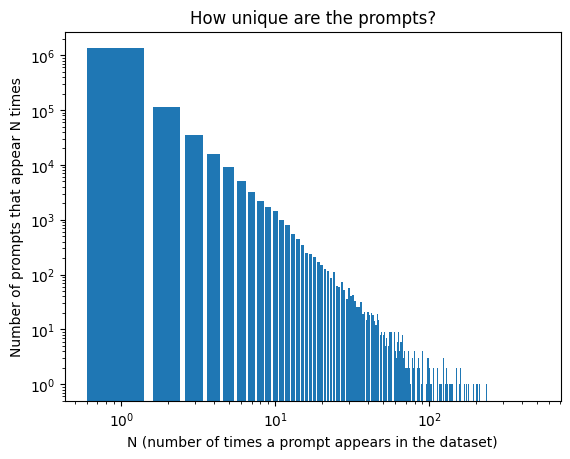

In [7]:
x = np.array([v for v in ct_dict.values()])
cts, bins = np.histogram(x, bins=np.unique(x))

plt.bar(bins[:-1], cts)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("N (number of times a prompt appears in the dataset)")
plt.ylabel("Number of prompts that appear N times")
plt.title("How unique are the prompts?")

# Prompt lengths?

By **specifier clauses** and **token length**

In [ ]:
# Choose separators, find token ids of that token
sep_ids = [",", ";", "|"]
for s in sep_ids:
    print(f"sep_id: '{s}': ", pipe.tokenizer.encode(f"know{s}nothing")[2:-2]) # ids of separator
    

In [ ]:
def batch_tok_length(text_inputs):
    """Calculate average number of tokens in input"""
    n_tokens = text_inputs["attention_mask"].sum(-1) - 2 # remove BOS and EOS added tags
    return n_tokens

def batch_concepts(prompt:str):
    """Return the concepts in each prompt as strings"""
    concepts = re.split(';|,|\|', prompt)
    return concepts

def batch_num_concepts(text_inputs):
    """Calculate how many concepts are in the prompt, from the tokens"""
    split_ids = [267, 282, 347] # comma, semicolon, pipe
    iids = text_inputs["input_ids"]
    mask = torch.zeros_like(iids)
    seps = [torch.eq(iids, sid) for sid in split_ids]
    for s in seps:
        mask = torch.logical_or(mask, s)
    out = mask.sum(-1) + 1 # Number of concepts = number of separators + 1
    return out

def tok_frequencies(text_inputs):
    """Calculate the frequency each token appears in a batch of tokenized inputs"""
    iids = text_inputs["input_ids"]
    ids, counts = torch.unique(iids, return_counts=True)
    return ids, counts

In [19]:
# !! Long running cell. Choose batch size that computer can handle easily
bs = 10000
i = 0
vocab_size = pipe.tokenizer.vocab_size
tokfreqs = torch.zeros(vocab_size, dtype=torch.int64)
total_nconcepts = torch.zeros(len(prompts), dtype=torch.int16)
total_token_length = torch.zeros(len(prompts), dtype=torch.int16)
total_iter = len(prompts) // bs + 1
nprompts = len(prompts)
n = 0
with tqdm(total=total_iter) as pbar:
    while i < nprompts:
        n+= 1
        pbar.update(1)
        pidxs = slice(i, i+bs)
        p = list(prompts.iloc[pidxs].prompt)
        text_inputs = pipe.tokenizer(
            p,
            padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        nconcepts = batch_num_concepts(text_inputs)
        total_nconcepts[pidxs] = nconcepts
        length = batch_tok_length(text_inputs)
        total_token_length[pidxs] = length

        ids, counts = tok_frequencies(text_inputs)
        tokfreqs[ids] += counts
        i += bs

        if n == total_iter:
            break

100%|████████████████████████████████████████▊| 200/201 [10:22<00:03,  3.11s/it]


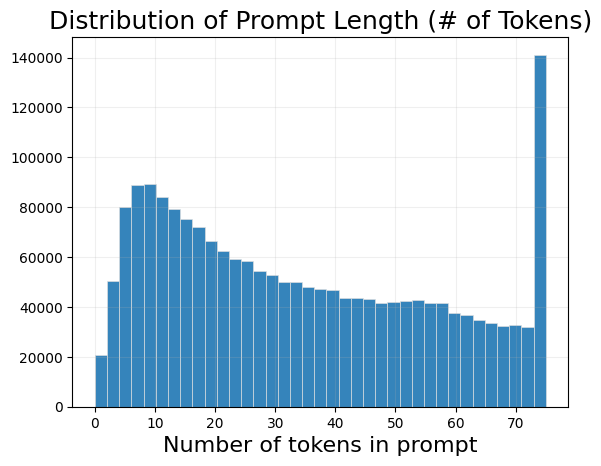

In [20]:
n, bins, patches = plt.hist(np.array(total_token_length), bins=37, edgecolor='#e0e0e0', linewidth=0.5, alpha=0.9)
n = n.astype("int")

plt.grid(alpha=0.2)
plt.xlabel("Number of tokens in prompt", fontsize=16)
plt.title("Distribution of Prompt Length (# of Tokens)", fontsize=18)
plt.savefig("figs/token_length_dist.png", dpi=350)

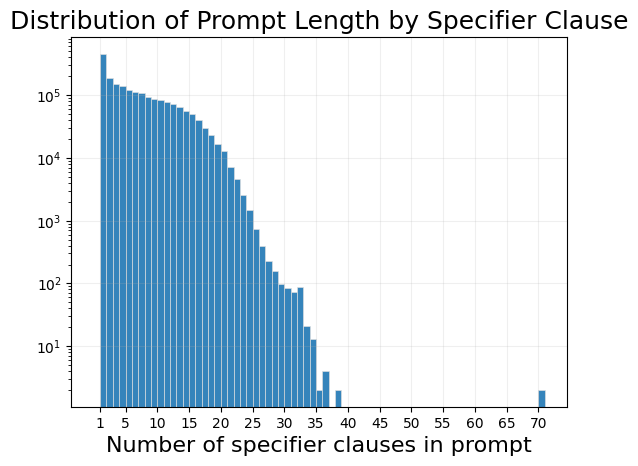

In [21]:
n, bins, patches = plt.hist(np.array(total_nconcepts), bins=range(0, np.unique(total_nconcepts).max().item()+1), edgecolor='#e0e0e0', linewidth=0.5, alpha=0.9)
plt.grid(alpha=0.2)
plt.xlabel("Number of specifier clauses in prompt", fontsize=16)
plt.yscale("log")
ticks = list(range(0, total_nconcepts.max().item(), 5)); ticks[0]=1
plt.xticks(ticks=ticks)
plt.title("Distribution of Prompt Length by Specifier Clause", fontsize=18)
plt.savefig("figs/spec_clause_length.png", dpi=350)

## Concept Frequency

A qualitative analysis of the concepts present in DiffusionDB. We manually filter the top tokens for stop words, combining subtoken representations into meaningful concepts, before displaying in a WordCloud.

In [22]:
# Show top K tokens in the corpus, visually filter as needed
cts, idxs = tokfreqs.topk(k=100)
print("\n".join([" :: ".join((str(pipe.tokenizer._convert_id_to_token(idx.item())), str(cts[i].item()))) for i, idx in enumerate(idxs)]))

<|endoftext|> :: 83099494
,</w> :: 10847176
<|startoftext|> :: 2000000
a</w> :: 1523457
of</w> :: 1296773
and</w> :: 1157827
by</w> :: 1110022
art</w> :: 784355
in</w> :: 756606
detailed</w> :: 714959
the</w> :: 709072
art :: 631981
.</w> :: 613519
on</w> :: 495852
station</w> :: 476150
painting</w> :: 438349
k</w> :: 429432
with</w> :: 425057
portrait</w> :: 399555
realistic</w> :: 365993
-</w> :: 342329
8</w> :: 323039
highly</w> :: 319087
lighting</w> :: 310602
digital</w> :: 295669
intricate</w> :: 276934
beautiful</w> :: 276268
concept</w> :: 256254
trending</w> :: 245511
greg</w> :: 245421
0</w> :: 239802
style</w> :: 235599
4</w> :: 235164
cinematic</w> :: 229357
sharp</w> :: 228603
rut :: 225678
kowski</w> :: 222008
render</w> :: 221661
illustration</w> :: 221422
an</w> :: 216964
focus</w> :: 210662
high</w> :: 188288
fantasy</w> :: 177511
octane</w> :: 176801
m</w> :: 172288
1</w> :: 170219
d</w> :: 167528
ger :: 166860
face</w> :: 162641
photo</w> :: 161967
light</w> :: 15578

In [24]:
# Filtered and combined tokens
words = {
  "art": 784355,
  "detailed": 714959,
  "artstation": 476150,
  "painting": 438349,
  "portrait": 399555,
  "realistic": 365993,
  "8k": 323039,
  "highly": 319087,
  "lighting": 310602,
  "digital": 295669,
  "intricate": 276934,
  "beautiful": 276268,
  "concept": 256254,
  "trending": 245511,
  "style": 235599,
  "4k": 235164,
  "cinematic": 229357,
  "sharp": 228603,
  "greg rutkowski": 222008,
  "render": 221661,
  "illustration": 221422,
  "focus": 210662,
  "high": 188288,
  "fantasy": 177511,
  "octane": 176801,
  "face":162641,
  "photo":161967,
  "light": 155787,
  "black": 131100,
  "wearing": 130106,
  "dark": 124368,
  "smooth": 120759,
  "white": 119682,
  "hyper": 117479,
  "unreal engine": 114896,
  "background": 114650,
  "elegant": 111326,
  "hair": 110355,
  "full": 109023,
  "mucha": 105940,
  "hyper": 107780,
}

print(len(words))

40


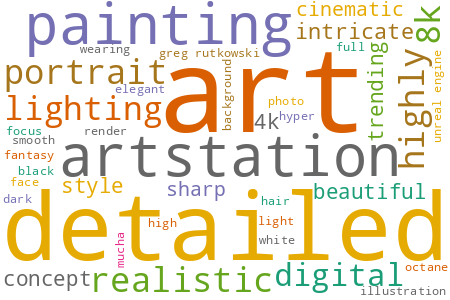

In [25]:
cloud = wc.WordCloud(width=450, height=300, background_color="white", min_font_size=10, relative_scaling=0.0001, colormap="Dark2").fit_words(words)
im = cloud.to_image()
im

In [26]:
im.save("figs/wordcloud_freqs.png", dpi=(450,450))